In [65]:
import pandas as pd
import glob
import uuid
import re
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
import random
import string
from nltk.tokenize import word_tokenize
import scipy
from scipy.stats import ttest_ind
from yellowbrick.text import FreqDistVisualizer
from seaborn import displot
from pingouin import welch_anova, read_dataset
from seaborn import kdeplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import statistics
from nltk.corpus import stopwords

In [66]:
def headline_summary_stats(directory='.'):
    """
    Concatenates all CSV files in the specified directory and filters based on 'metric_event_id'.

    Parameters:
    directory (str): The directory containing CSV files. Default is the current directory.

    Returns:
    dict: A dictionary containing various statistics.
    """
    # Get list of CSV files
    file_list = glob.glob(f"{directory}/*.csv")

    # Read CSV files into list of DataFrames
    dfs = [pd.read_csv(file) for file in file_list]

    # Replace spaces with underscores, convert to lowercase for column names
    for df in dfs:
        df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Concatenate DataFrames
    concatenated_df = pd.concat(dfs, ignore_index=True)

    # Filter based on 'metric_event_name'
    concatenated_df = concatenated_df[concatenated_df['metric_event_name'].str.contains('Headline click', case=False)]

    # Assuming headline_clicks is your DataFrame
    unique_start_times = concatenated_df['start_time_(utc)'].unique()

    # Creating a dictionary to map unique start times to experiment IDs
    experiment_mapping = {start_time: str(uuid.uuid4())[:12] for start_time in unique_start_times}

    # Creating a new 'experiment' column based on the mapping
    concatenated_df['experiment'] = concatenated_df['start_time_(utc)'].map(experiment_mapping)

    experiment_count = len(concatenated_df['experiment'].unique())
    
    treatment_groups = concatenated_df[concatenated_df['is_baseline_variation'] == False]
    
    winners = concatenated_df[concatenated_df['improvement_status_from_baseline'] == 'better']
    
    stats_sig_winners = winners[winners['is_improvement_significant'] == True]

    uplift = concatenated_df.improvement_value_from_baseline

    # Create a new column named "statement_question"
    concatenated_df['statement_question'] = concatenated_df['variation_name'].apply(lambda x: "Question" if "?" in x else "Statement")

    # Separate the data into statement and question groups
    statement_group = concatenated_df[concatenated_df['statement_question'] == 'Statement']
    question_group = concatenated_df[concatenated_df['statement_question'] == 'Question']

    # Perform a two-sample t-test between the groups
    t_statistic_s_v_q, p_value_s_v_q = ttest_ind(statement_group['metric_value'], question_group['metric_value'], equal_var=False)

    concatenated_df['time_of_day'] = pd.to_datetime(concatenated_df['start_time_(utc)']).dt.hour

    # Create 6 bins for the 'time_of_day' column, with each bin representing 4 hours
    concatenated_df['time_of_day_bucket'] = pd.cut(concatenated_df['time_of_day'], bins=6, labels=['00:00-03:59', '04:00-07:59', '08:00-11:59', '12:00-15:59', '16:00-19:59', '20:00-23:59'], ordered=True)

    # Convert time_of_day_bucket column to string values
    concatenated_df['time_of_day_bucket'] = concatenated_df['time_of_day_bucket'].astype('str')

    # Convert the time_of_day_bucket column to an ordered categorical column
    concatenated_df['time_of_day_bucket'] = pd.Categorical(concatenated_df['time_of_day_bucket'], ordered=True)
    
    # Manually order the time of day buckets
    ordered_buckets = ['00:00-03:59', '04:00-07:59', '08:00-11:59', '12:00-15:59', '16:00-19:59', '20:00-23:59']

    character_count = concatenated_df['variation_name'].str.len()
    metric_value = concatenated_df['metric_value']

    character_count = np.array(character_count, dtype=float)
    metric_value = np.array(metric_value, dtype=float)

    # Calculate the correlation coefficient (r) and p-value
    r, p = pearsonr(character_count, metric_value)

    # Calculate the linear regression coefficients using numpy.polyfit()
    coefficients = np.polyfit(character_count, metric_value, 1)

    # Calculate the r-squared value
    r_squared = 1 - np.sum((metric_value - np.polyval(coefficients, character_count))**2) / np.var(metric_value)

    anova_tod = welch_anova(dv='metric_value', between='time_of_day_bucket', data=concatenated_df)

    anova_tod_p = anova_tod['p-unc'].values[0]  # Assuming 'p-unc' is the key for the p-value

    stats_1 = {
        "experiment_count": experiment_count,
        "average_conversion_rate": round(100 * concatenated_df.metric_value.mean(),2),
        "treatment_group_count": len(treatment_groups),
        "winning_variants_percentage": round(100 * len(winners) / len(treatment_groups), 2),
        "statistical_significance_percentage": round(100 * len(stats_sig_winners) / len(winners), 2),
        "overall_win_rate": round(100 * len(stats_sig_winners) / len(treatment_groups), 2),
        "average_uplift": round(100*(uplift.mean()),2),
        "max_uplift" : round(100*(uplift.max()),2),
        "min_uplift" : round(100*(uplift.min()),2),
        "std_uplift" : round(uplift.std(),2),
        "t_stat_questions_vs_statements": round(t_statistic_s_v_q,2),
        "p_val_questions_vs_statements": round(p_value_s_v_q,2),
        "p_val_time_of_day": round(anova_tod_p,2)
        
    }

    return stats_1

# Example usage:
# stats = concat_and_filter_csv('/path/to/directory')
# print("There have been:", stats["experiment_count"], "experiments conducted.")
# print("The average conversion rate of all headlines was:", stats["average_conversion_rate"], "%.")
# print("Of the", stats["experiment_count"], "there were:", stats["treatment_group_count"], "treatment groups.")
# print("Of these variants:", stats["winning_variants_percentage"], "% outperformed the control.")
# print("Of these winning variants:", stats["statistical_significance_percentage"], "% detected statistical significance.")
# print("The overall win rate for treatment groups was:", stats["overall_win_rate"], "%")


In [67]:
headline_summary_stats()

{'experiment_count': 196,
 'average_conversion_rate': 2.82,
 'treatment_group_count': 944,
 'winning_variants_percentage': 39.83,
 'statistical_significance_percentage': 61.7,
 'overall_win_rate': 24.58,
 'average_uplift': 0.44,
 'max_uplift': 323.88,
 'min_uplift': -76.51,
 'std_uplift': 0.48,
 't_stat_questions_vs_statements': -0.24,
 'p_val_questions_vs_statements': 0.81,
 'p_val_time_of_day': 0.0}

In [68]:
def headline_visualisations(directory='.'):
    """
    Concatenates all CSV files in the specified directory and filters based on 'metric_event_id'.

    Parameters:
    directory (str): The directory containing CSV files. Default is the current directory.

    Returns:
    dict: A dictionary containing various statistics.
    """
    # Get list of CSV files
    file_list = glob.glob(f"{directory}/*.csv")

    # Read CSV files into list of DataFrames
    dfs = [pd.read_csv(file) for file in file_list]

    # Replace spaces with underscores, convert to lowercase for column names
    for df in dfs:
        df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Concatenate DataFrames
    concatenated_df = pd.concat(dfs, ignore_index=True)

    # Filter based on 'metric_event_name'
    concatenated_df = concatenated_df[concatenated_df['metric_event_name'].str.contains('Headline click', case=False)]

    # Assuming headline_clicks is your DataFrame
    unique_start_times = concatenated_df['start_time_(utc)'].unique()

    # Creating a dictionary to map unique start times to experiment IDs
    experiment_mapping = {start_time: str(uuid.uuid4())[:12] for start_time in unique_start_times}

    # Creating a new 'experiment' column based on the mapping
    concatenated_df['experiment'] = concatenated_df['start_time_(utc)'].map(experiment_mapping)

    experiment_count = len(concatenated_df['experiment'].unique())
    
    treatment_groups = concatenated_df[concatenated_df['is_baseline_variation'] == False]
    
    winners = concatenated_df[concatenated_df['improvement_status_from_baseline'] == 'better']
    
    stats_sig_winners = winners[winners['is_improvement_significant'] == True]

    uplift = concatenated_df.improvement_value_from_baseline

    # Create a new column named "statement_question"
    concatenated_df['statement_question'] = concatenated_df['variation_name'].apply(lambda x: "Question" if "?" in x else "Statement")

    # Separate the data into statement and question groups
    statement_group = concatenated_df[concatenated_df['statement_question'] == 'Statement']
    question_group = concatenated_df[concatenated_df['statement_question'] == 'Question']

    # Perform a two-sample t-test between the groups
    t_statistic_s_v_q, p_value_s_v_q = ttest_ind(statement_group['metric_value'], question_group['metric_value'], equal_var=False)

    concatenated_df['time_of_day'] = pd.to_datetime(concatenated_df['start_time_(utc)']).dt.hour

    # Create 6 bins for the 'time_of_day' column, with each bin representing 4 hours
    concatenated_df['time_of_day_bucket'] = pd.cut(concatenated_df['time_of_day'], bins=6, labels=['00:00-03:59', '04:00-07:59', '08:00-11:59', '12:00-15:59', '16:00-19:59', '20:00-23:59'], ordered=True)

    # Convert time_of_day_bucket column to string values
    concatenated_df['time_of_day_bucket'] = concatenated_df['time_of_day_bucket'].astype('str')

    # Convert the time_of_day_bucket column to an ordered categorical column
    concatenated_df['time_of_day_bucket'] = pd.Categorical(concatenated_df['time_of_day_bucket'], ordered=True)
    
    # Manually order the time of day buckets
    ordered_buckets = ['00:00-03:59', '04:00-07:59', '08:00-11:59', '12:00-15:59', '16:00-19:59', '20:00-23:59']

    character_count = concatenated_df['variation_name'].str.len()
    metric_value = concatenated_df['metric_value']

    character_count = np.array(character_count, dtype=float)
    metric_value = np.array(metric_value, dtype=float)

    # Calculate the correlation coefficient (r) and p-value
    r, p = pearsonr(character_count, metric_value)

    # Calculate the linear regression coefficients using numpy.polyfit()
    coefficients = np.polyfit(character_count, metric_value, 1)

    # Calculate the r-squared value
    r_squared = 1 - np.sum((metric_value - np.polyval(coefficients, character_count))**2) / np.var(metric_value)
    
    # Create the scatter plot
    plt.figure()
    plt.scatter(character_count, metric_value)
    
    # Plot the trendline
    trendline_x = np.linspace(min(character_count), max(character_count), 100)
    trendline_y = np.polyval(coefficients, trendline_x)
    plt.plot(trendline_x, trendline_y, color='red')
    
    # Label the axes and add a title
    plt.xlabel('Character Count')
    plt.ylabel('Metric Value')
    plt.title('Relationship Between Character Count and Conversion Rate')
    
    # Add the r-squared and p-value to the plot
    plt.annotate(f"r^2 = {r:.3f}, p = {p:.3f}", xy=(20, 14))

    # Create a boxplot
    plt.figure()
    bp = plt.boxplot([statement_group['metric_value'], question_group['metric_value']],
                     notch=True, patch_artist=True, vert=True, labels=['Statements', 'Questions'])

    # Add labels and title
    plt.xlabel('Statement/Question')
    plt.ylabel('Metric Value')
    plt.title('Comparison of Conversion Rates Between Statements and Questions')
    
    # Show the plot
    plt.ylim(-0.02,0.1)
    plt.show()

    # Create the boxplot with manually ordered categories
    sb.boxplot(x = concatenated_df['time_of_day_bucket'], y = concatenated_df['metric_value'])

    concatenated_df['date'] = pd.to_datetime(concatenated_df['start_time_(utc)']).dt.date

    # Count the number of experiment_ids for each date
    experiment_id_counts = concatenated_df.groupby('date')['experiment'].nunique()
    
    # Create a DataFrame from the counts
    experiment_id_counts_df = pd.DataFrame({'count': experiment_id_counts}).reset_index()
    experiment_id_counts_df.columns = ['date', 'count_of_experiment_ids']
    
    # Sort the DataFrame by date
    experiment_id_counts_df = experiment_id_counts_df.sort_values(by='date')

    # Plot the count of experiment_ids over date
    plt.figure(figsize=(10, 6))
    plt.plot(experiment_id_counts_df['date'], experiment_id_counts_df['count_of_experiment_ids'])
    plt.xlabel('Date')
    plt.ylabel('Count of Experiment IDs')
    plt.title('Number of Experiment IDs per Date')
    plt.grid(False)
    plt.ylim(-2,10)
    plt.show()


    return

# Example usage:
# stats = concat_and_filter_csv('/path/to/directory')
# print("There have been:", stats["experiment_count"], "experiments conducted.")
# print("The average conversion rate of all headlines was:", stats["average_conversion_rate"], "%.")
# print("Of the", stats["experiment_count"], "there were:", stats["treatment_group_count"], "treatment groups.")
# print("Of these variants:", stats["winning_variants_percentage"], "% outperformed the control.")
# print("Of these winning variants:", stats["statistical_significance_percentage"], "% detected statistical significance.")
# print("The overall win rate for treatment groups was:", stats["overall_win_rate"], "%")


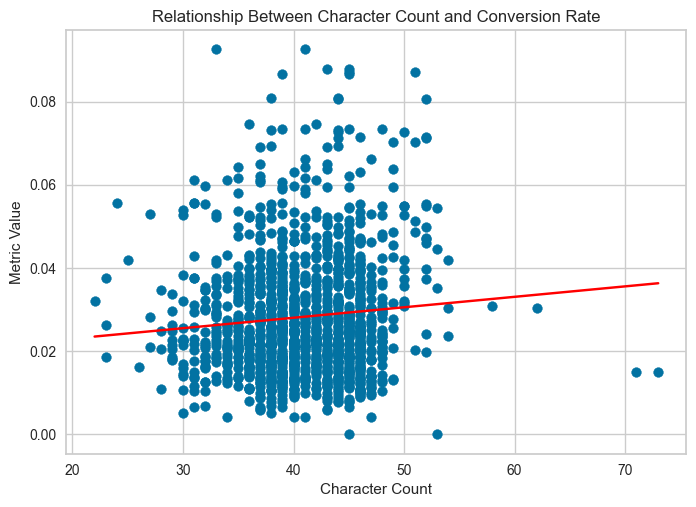

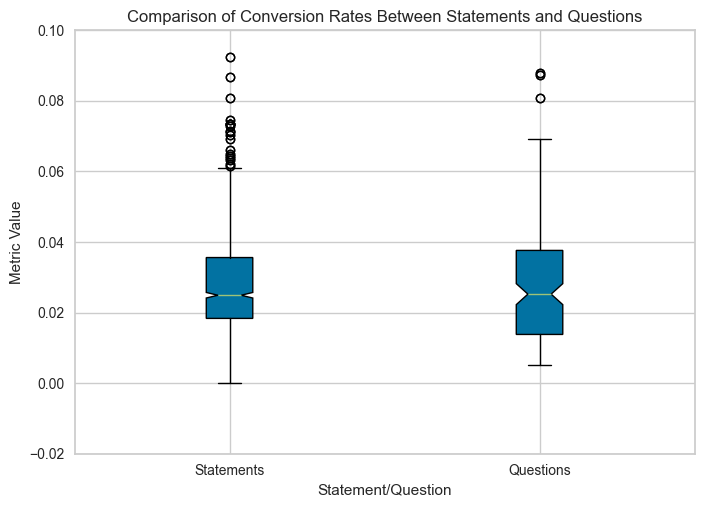

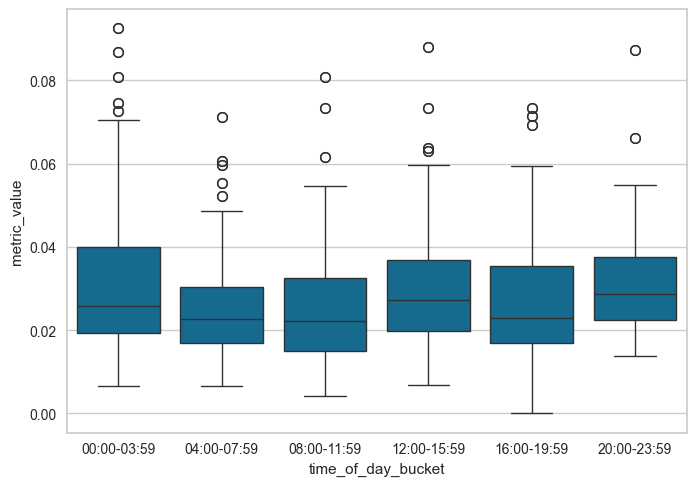

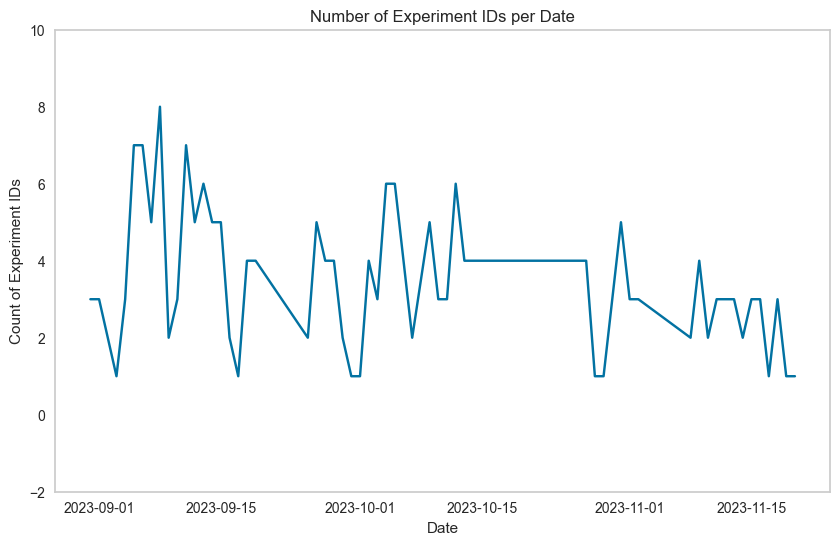

In [69]:
headline_visualisations()

In [72]:
def headline_sentiment_analysis(directory='.'):
    """
    Concatenates all CSV files in the specified directory and filters based on 'metric_event_id'.

    Parameters:
    directory (str): The directory containing CSV files. Default is the current directory.

    Returns:
    dict: A dictionary containing various statistics.
    """
    # Get list of CSV files
    file_list = glob.glob(f"{directory}/*.csv")

    # Read CSV files into list of DataFrames
    dfs = [pd.read_csv(file) for file in file_list]

    # Replace spaces with underscores, convert to lowercase for column names
    for df in dfs:
        df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Concatenate DataFrames
    concatenated_df = pd.concat(dfs, ignore_index=True)

    # Filter based on 'metric_event_name'
    concatenated_df = concatenated_df[concatenated_df['metric_event_name'].str.contains('Headline click', case=False)]

    headline_list = concatenated_df.variation_name.tolist()

    sentiments = []
    
    for headline in headline_list:
        blob = TextBlob(headline)
        sentiment = {
            "headline": headline,
            "polarity": blob.sentiment.polarity,
            "subjectivity": blob.sentiment.subjectivity
        }
        sentiments.append(sentiment)

    df_headlines = pd.DataFrame(sentiments)

    stats_1 = {
        "average_polarity": statistics.mean(df_headlines.polarity),
        "average_subjectivity": statistics.mean(df_headlines.subjectivity)
        
    }

    concatenated_df['polarity'] = df_headlines.polarity
    concatenated_df['subjectivity'] = df_headlines.subjectivity

    # Extract the character count and metric value from the data
    polarity = df_headlines.polarity
    metric_value = concatenated_df['metric_value']
    
    # Assuming you have already extracted polarity and metric_value from your data
    
    # Calculate the correlation coefficient (r) and p-value
    r, p = stats.pearsonr(polarity, metric_value)
    
    # Calculate the linear regression coefficients using numpy.polyfit()
    coefficients = np.polyfit(polarity, metric_value, 1)
    
    # Calculate the r-squared value
    r_squared = 1 - np.sum((metric_value - np.polyval(coefficients, polarity))**2) / np.var(metric_value)
    
    # Create the scatter plot
    plt.figure()
    plt.scatter(polarity, metric_value)
    
    # Plot the trendline
    plt.plot(polarity, np.polyval(coefficients, polarity), color='red', label=f'Trendline: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
    
    # Label the axes and add a title
    plt.xlabel('Polarity')
    plt.ylabel('Metric Value')
    plt.title('Relationship Between Polarity and Conversion Rate')
    
    # Add the r-squared and p-value to the plot
    plt.annotate(f"r^2 = {r_squared:.3f}, p = {p:.3f}", xy=(20, 14))
    
    # Show the plot
    plt.legend()
    plt.ylim(-0.05, 0.15)
    plt.show()
    
    print(r, p)

    # Extract the character count and metric value from the data
    subjectivity = df_headlines.subjectivity
    metric_value = concatenated_df['metric_value']
    
    # Assuming you have already extracted subjectivity and metric_value from your data
    
    # Calculate the correlation coefficient (r) and p-value
    r, p = stats.pearsonr(subjectivity, metric_value)
    
    # Calculate the linear regression coefficients using numpy.polyfit()
    coefficients = np.polyfit(subjectivity, metric_value, 1)
    
    # Calculate the r-squared value
    r_squared = 1 - np.sum((metric_value - np.polyval(coefficients, subjectivity))**2) / np.var(metric_value)
    
    # Create the scatter plot
    plt.figure()
    plt.scatter(subjectivity, metric_value)
    
    # Plot the trendline
    plt.plot(subjectivity, np.polyval(coefficients, subjectivity), color='red', label=f'Trendline: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
    
    # Label the axes and add a title
    plt.xlabel('subjectivity')
    plt.ylabel('Metric Value')
    plt.title('Relationship Between subjectivity and Conversion Rate')
    
    # Add the r-squared and p-value to the plot
    plt.annotate(f"r^2 = {r_squared:.3f}, p = {p:.3f}", xy=(20, 14))
    
    # Show the plot
    plt.legend()
    plt.ylim(-0.05, 0.15)
    plt.show()
    
    print(r, p)

    return stats_1

# Example usage:
# stats = concat_and_filter_csv('/path/to/directory')
# print("There have been:", stats["experiment_count"], "experiments conducted.")
# print("The average conversion rate of all headlines was:", stats["average_conversion_rate"], "%.")
# print("Of the", stats["experiment_count"], "there were:", stats["treatment_group_count"], "treatment groups.")
# print("Of these variants:", stats["winning_variants_percentage"], "% outperformed the control.")
# print("Of these winning variants:", stats["statistical_significance_percentage"], "% detected statistical significance.")
# print("The overall win rate for treatment groups was:", stats["overall_win_rate"], "%")


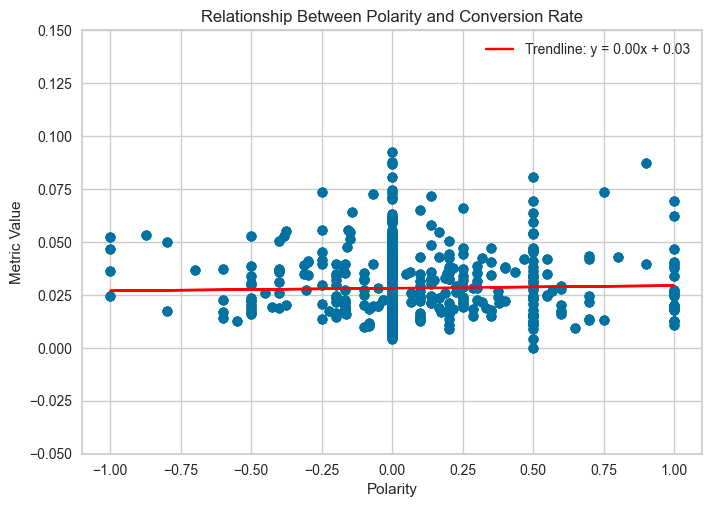

0.02458506087924474 0.36887404901906223


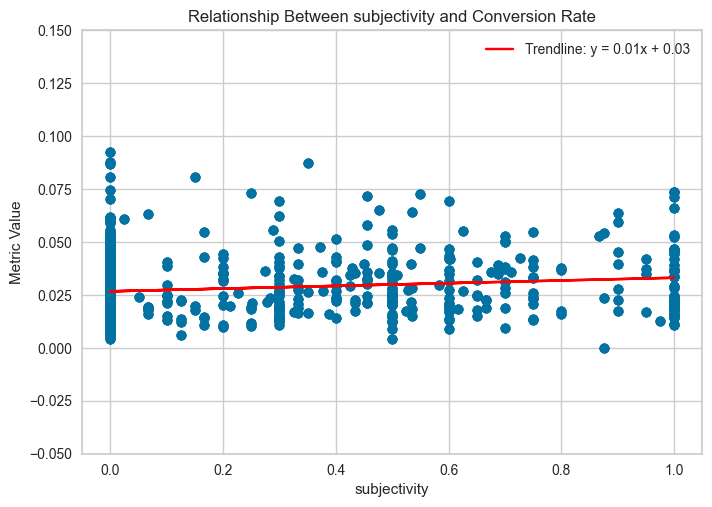

0.14188657557246026 1.8725918330598687e-07


{'average_polarity': 0.06237087132266504,
 'average_subjectivity': 0.23991752351617823}

In [73]:
headline_sentiment_analysis()